In [2]:
# Scientific libraries
              
import numpy as np              
import scipy as sp              
import pandas as pd              
import json              
import missingno as msno              

# Loading Plotting Modules
              
import matplotlib              
import matplotlib.pyplot as plt              
import seaborn as sns              
%matplotlib inline              
import chart_studio.plotly as py              
import plotly.figure_factory as ff              
import plotly.graph_objects as go              
import plotly.express as px              
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot              
init_notebook_mode(connected=True)              

# Setting Data Frame Options
              
pd.set_option('display.max_rows', 40)              
pd.set_option('display.max_columns', 50)              
pd.set_option('display.width', 100)              
pd.set_option('display.max_colwidth', 100)              

# Setting Plot Configuration
              
sns.set(rc={'figure.figsize':(19,11)}, style = 'white')              

import katana.nbutil as ktn
              
import os

In [4]:
import configparser

wd = os.getcwd()
pardir = os.path.join(wd, os.pardir, )

_CFG_FILE = os.path.join(pardir, os.pardir, 'default.cfg')

cfg = configparser.ConfigParser()
cfg.read(_CFG_FILE)
categoric_trs = json.loads(cfg['default']['categoric_transaction'])
categoric_id = json.loads(cfg['default']['categoric_id'])

## Data set

We will only use transaction dataset and we will not be using identity data set for the first part as identity data would yield huge amount of missing values. Instead we would go for optimizing missing rows/columns for transaction data set only.

In [119]:
df_train = pd.read_csv('../../data/train_transaction.csv.zip')               
m_train, n_train = df_train.shape
print('Data Frame: {} x {}'.format(m_train,n_train))                
df_train.head()

Data Frame: 590540 x 394


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,...,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Will not be using this part.
# df_train_idx = pd.read_csv('../data/train_identity.csv.zip')
# print('DataFrame: %d x %d' % df_train_idx.shape)
# df_train_idx.head()

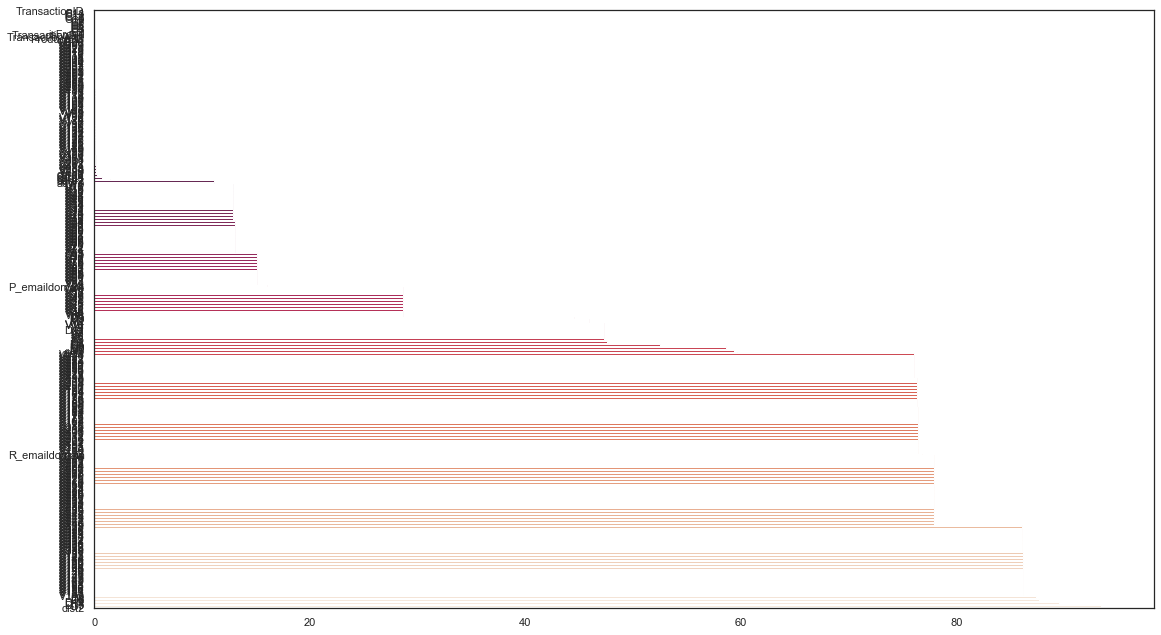

In [120]:
train_na_counts = df_train.isna().sum().sort_values()
train_na_counts = 100*(train_na_counts / df_train.shape[0])
sns.barplot(y=train_na_counts.index, x= train_na_counts,
           palette='rocket')
None

In [121]:
def highlight_bg(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'yellow' if isinstance(val, str) else ''
    return 'background-color: %s' % color

def missing_percentage(cols:list, df):
    result = pd.DataFrame()
    col_names = []
    for col in cols:
        dict_table = {}
        series = 100*(df[col].value_counts(dropna=False)/df.shape[0])
        cats = pd.Series(series.index.ravel())
        cats = cats.apply(str)
        vals = series.values.ravel()
        dict_table[col+'_cats'] = cats
        dict_table[col] = vals
        col_names.extend(dict_table.keys())
        result = pd.concat([result,pd.DataFrame(dict_table)], ignore_index=True, axis=1)
    result.columns = col_names
    result.to_csv('missing_categorical.csv.gz', compression='gzip')
    result = result.style.applymap(highlight_bg)
    return result

In [122]:
threshold = int(m_train*.95)
df_train.dropna(thresh=threshold, axis=1, inplace=True)

In [123]:
print('Train shape:', df_train.shape)

Train shape: (590540, 112)


In [124]:
(100*(df_train.isna().sum()/df_train.shape[0])).sort_values(ascending=False)

card2             1.512683
card5             0.721204
card4             0.267044
card6             0.266028
card3             0.265012
V283              0.214888
V282              0.214888
V300              0.214888
V301              0.214888
V289              0.214888
V288              0.214888
V281              0.214888
D1                0.214888
V313              0.214888
V314              0.214888
V315              0.214888
V296              0.214888
V133              0.053172
V117              0.053172
V118              0.053172
                    ...   
TransactionDT     0.000000
card1             0.000000
ProductCD         0.000000
TransactionAmt    0.000000
C2                0.000000
isFraud           0.000000
C1                0.000000
C6                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C

In [125]:
categoric_feature_set = set(categoric_trs)
train_feature_set = set(df_train.columns.tolist())
new_categorical_features = list(categoric_feature_set.intersection(train_feature_set))
new_numeric_features = list(train_feature_set - categoric_feature_set)

In [126]:
fillna_dict = {}
for f in categoric_feature_set:
    fillna_dict[f] = 'Other'

In [129]:
df_train.fillna(value=fillna_dict, inplace=True)

In [132]:
df_train[new_categorical_features].isna().sum()

ProductCD    0
card3        0
card6        0
card1        0
card2        0
card5        0
card4        0
dtype: int64

In [134]:
X = df_train.dropna()

In [135]:
X.shape

(589099, 112)

In [136]:
for col in new_categorical_features:
    cls_size = X[col].nunique()
    print(f'{cls_size} classes for column {col}')

5 classes for column ProductCD
115 classes for column card3
5 classes for column card6
13537 classes for column card1
501 classes for column card2
120 classes for column card5
5 classes for column card4


In [103]:
categoric_trs.extend(categoric_id)

In [109]:
categoric_features = categoric_trs

In [111]:
train_cols = train.columns
numeric_features = train_cols[~train_cols.isin(categoric_features)]

### Missing Cases
Train Identity data frame contains roughly 1/5 rows of the Transaction DataFrame, so many of the transaction data frame would be missing.
#### 1. Merging
Joining two tables would not be appropriate if missing cases would outnumber the whole data. Thus, want to eliminate columns that has many missing. Otherwise, we eliminate missing values row-wise.

In [115]:
(train[numeric_features].isna().sum()>280000)

isFraud           False
TransactionDT     False
TransactionAmt    False
dist1              True
C1                False
C2                False
C3                False
C4                False
C5                False
C6                False
C7                False
C8                False
C9                False
C10               False
C11               False
C12               False
C13               False
C14               False
D1                False
D2                 True
                  ...  
V311              False
V312              False
V313              False
V314              False
V315              False
V316              False
V317              False
V318              False
V319              False
V320              False
V321              False
id_01              True
id_02              True
id_03              True
id_04              True
id_05              True
id_06              True
id_09              True
id_10              True
id_11              True
Length: 215, dty